# Unsupervised Learning on LendingClub data
Can Kmeans, MiniBatch Kmeans and MeanShift predict a good vs a bad loan?

1. Use 2 cluster to see how well Kmean and miniKmeans can predict good loans
2. Use the top 10 features in Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import MeanShift, SpectralClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize, scale
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('lending_club_le.csv')

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.head(3)

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,out_prncp,collections_12_mths_ex_med,open_acc_6m,mths_since_rcnt_il,il_util,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,earliest_cr_line,revol_util,initial_list_status,application_type
0,3000.0,52000.0,0.58,0.0,0.0,0.0,0.0,0.0,7.0,67.990156,...,9,3,1,0,5,46,253,5,1,0
1,5000.0,55000.0,14.18,0.0,0.0,0.0,0.0,1.0,33.0,63.000000,...,1,2,0,0,8,10,90,346,1,0
2,20300.0,55000.0,26.63,0.0,0.0,0.0,0.0,0.0,24.0,74.000000,...,10,3,2,0,1,33,523,756,1,0


In [5]:
df.shape

(87923, 46)

In [6]:
df.good_loan_status.value_counts()

1    65793
0    22130
Name: good_loan_status, dtype: int64

---

---

# Kmeans vs MiniBatchKmeans analysis

How accurately will Kmeans cluster data into good and bad loan data?

## Kmeans

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


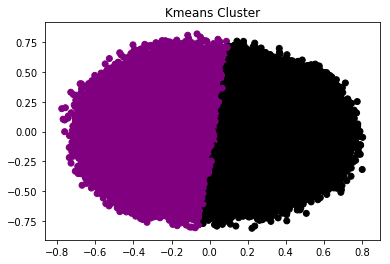

Comparing k-means clusters against the data:
good_loan_status      0      1
row_0                         
0                 10540  27965
1                 11590  37828


In [7]:
colormap = np.array(['black', 'Purple'])
X_norm = normalize(scale(df.drop(['good_loan_status'], axis=1)))
X_pca = PCA(2).fit_transform(X_norm)
y_pred = KMeans(n_clusters=2, random_state=42, n_jobs=-1).fit_predict(X_pca)

# Plot the solution.
plt.title('Kmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[y_pred])
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, df['good_loan_status']))

_PCA is used to reduce the data to 2 components because we are looking to see if Kmeans can predict a good loan_

Looks like this model isn't doing very well. We're __correctly classifying 44,298 (33717+10581)__ cases, but __mis-classifying 43,625 (32076+11549)__ of the cases!

Out of __87,923__ loan applicatons __33717__ were good loans which were predict correctly. There are way to many false positives(__32076__).


-----

## Kmeans Mini Batch

_Let's look at MiniBatch to see if that would be better_

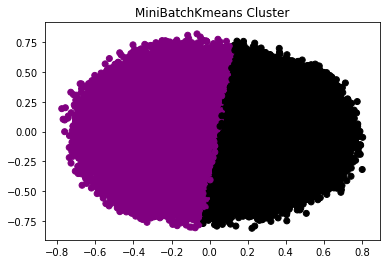

Comparing k-means and mini batch k-means solutions:
good_loan_status      0      1
row_0                         
0                 10201  27012
1                 11929  38781


In [8]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=250)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)
# Plot the solution.
colormap = np.array(['black', 'Purple'])
plt.title('MiniBatchKmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, df['good_loan_status']))

MiniBatch Kmeans is able to __classify 43,207 (32263+10944)___ and __mis-classify 44,716 (11186+33530)__.

-----

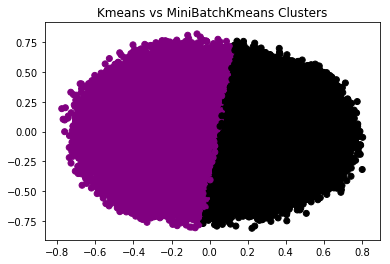

Comparing k-means and mini batch k-means solutions:
col_0      0      1
row_0              
0      37213      0
1       1292  49418


In [9]:
colormap = np.array(['black', 'Purple'])
plt.title('Kmeans vs MiniBatchKmeans Clusters')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Both KMeans and Kmeans minibatch were not able to cluster good loans.  They both had a high rate of false positives.

-------

# Clustering the Top 10 Random Forest features
_I will take the top 10 features from the Random Forest supervised learning
I will run it on both Kmeans and MeanShift_

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

df1 = pd.read_csv('lending_club_le.csv')
df1.drop('Unnamed: 0', axis=1, inplace=True)

_Create the dataframes of the top 10 features_

In [11]:
topFeatures = df1[['out_prncp',
                      'term',
                      'loan_amnt',
                      'months_since_issue_d',
                      'loan_amnt',
                      'tot_hi_cred_lim',
                      'home_ownership',
                      'avg_cur_bal',
                      'verification_status',
                      'bc_util',
                      'dti',
                      'good_loan_status']]

_Elbow method to determine the number of clusters_

In [12]:
# function to determine K
def kClusters(X):
    plt.rcParams['figure.figsize'] = [9, 5]

    squaredSums = []
    K = range(1, 15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel = kmeanModel.fit(X)
        squaredSums.append(kmeanModel.inertia_)

    # Plot the elbow
    plt.plot(K, squaredSums, 'bx-')
    plt.xlabel('k')
    plt.ylabel('squaredSums')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

---

## KMeans RFC top 10 feature analysis

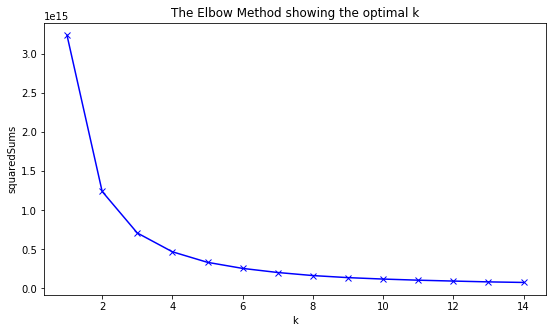

In [13]:
kClusters(topFeatures)

In [14]:
norm = Normalizer(copy=False)
X_normalized = norm.fit_transform(topFeatures)

km = KMeans(n_clusters=4,
               init='k-means++')

km_clusters = km.fit_predict(X_normalized)
#ylabels = km.predict(topFeatures)

centroids = km.cluster_centers_
km_labels = km.labels_

topFeatures['clusters'] = km_clusters

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [15]:
clusterList = [0, 1, 2, 3]
for var in clusterList:
    print('cluster'+str(var))
    print(topFeatures[topFeatures['clusters'] == var]
          ['good_loan_status'].mean())

cluster0
0.811275662859186
cluster1
0.6140350877192983
cluster2
0.6987325009458948
cluster3
0.4844703272323905


In [36]:
for var in clusterList:
    print('cluster'+str(var))
    print(topFeatures[topFeatures['clusters'] == var].describe())

cluster0
          out_prncp          term     loan_amnt  months_since_issue_d  \
count  53141.000000  53141.000000  53141.000000          53141.000000   
mean     988.892349      0.237688  13410.204456              9.228853   
std     4290.891807      0.425671   9772.564863              3.580936   
min        0.000000      0.000000   1000.000000              0.000000   
25%        0.000000      0.000000   6000.000000              6.950820   
50%        0.000000      0.000000  10000.000000              9.967213   
75%        0.000000      0.000000  19600.000000             11.967213   
max    40000.000000      1.000000  40000.000000             13.901639   

          loan_amnt  tot_hi_cred_lim  home_ownership    avg_cur_bal  \
count  53141.000000     5.314100e+04    53141.000000   53141.000000   
mean   13410.204456     2.747694e+05        1.527333   21473.565684   
std     9772.564863     2.019958e+05        0.818532   20582.837425   
min     1000.000000     7.300000e+03        0.000

In [17]:
dict = {}
for var in zip(topFeatures, km_labels):
    dict[var[0]] = var[1]
dict    

{'out_prncp': 0,
 'term': 0,
 'loan_amnt': 0,
 'months_since_issue_d': 0,
 'tot_hi_cred_lim': 2,
 'home_ownership': 1,
 'avg_cur_bal': 2,
 'verification_status': 0,
 'bc_util': 0,
 'dti': 0,
 'good_loan_status': 1,
 'clusters': 0}

In [18]:
km_clusters = pd.DataFrame(list(dict.items()), 
                           columns=['Features', 
                                    'Cluster'])

In [19]:
km_clusters.sort_values(by=['Cluster'], 
                        ascending=[True])

,Features,Cluster
0,out_prncp,0
1,term,0
2,loan_amnt,0
3,months_since_issue_d,0
7,verification_status,0
8,bc_util,0
9,dti,0
11,clusters,0
5,home_ownership,1
10,good_loan_status,1


In [20]:
km_clusters.Cluster.value_counts()

0    8
2    2
1    2
Name: Cluster, dtype: int64

In [21]:
km_clusters[km_clusters['Cluster'] == 0]

,Features,Cluster
0,out_prncp,0
1,term,0
2,loan_amnt,0
3,months_since_issue_d,0
7,verification_status,0
8,bc_util,0
9,dti,0
11,clusters,0


In [33]:
km_clusters[km_clusters['Cluster'] == 1]

,Features,Cluster
5,home_ownership,1
10,good_loan_status,1


In [34]:
km_clusters[km_clusters['Cluster'] == 2]

,Features,Cluster
4,tot_hi_cred_lim,2
6,avg_cur_bal,2


---------

## Mean shift top 10 feature analysis

In [24]:
topFeatures2 = topFeatures.drop(
    ['good_loan_status', 'clusters'], axis=1)

In [25]:
bandwidth2 = estimate_bandwidth(topFeatures2,
                                quantile=0.2,
                                n_samples=10)
# introduce the radius, also create bins to store the clusters.
ms = MeanShift(bandwidth2, 
               bin_seeding=True)

In [26]:
ms.fit(topFeatures2)
msLabels = ms.labels_

In [27]:
msLabels

array([0, 0, 0, ..., 1, 0, 0])

In [29]:
dict1 = {}
for var in zip(topFeatures2, msLabels):
    dict1[var[0]] = var[1]
    # if var[1] == 65:
    # print(var)

_This dictionary has the feature and the cluster number it belongs too_

In [30]:
dict1

{'out_prncp': 0,
 'term': 0,
 'loan_amnt': 0,
 'months_since_issue_d': 0,
 'tot_hi_cred_lim': 0,
 'home_ownership': 0,
 'avg_cur_bal': 0,
 'verification_status': 0,
 'bc_util': 0,
 'dti': 33}

In [31]:
clusters = pd.DataFrame(list(dict1.items()), columns=[
                        'Features', 'Cluster'])
clusters

,Features,Cluster
0,out_prncp,0
1,term,0
2,loan_amnt,0
3,months_since_issue_d,0
4,tot_hi_cred_lim,0
5,home_ownership,0
6,avg_cur_bal,0
7,verification_status,0
8,bc_util,0
9,dti,33


In [32]:
clusters['Cluster'].value_counts()

0     9
33    1
Name: Cluster, dtype: int64

_MeanShift grouped the 9 feautes in one cluster, cluster 0 and dti feature in a cluster._